In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

(2704, 7)
(2704, 2)


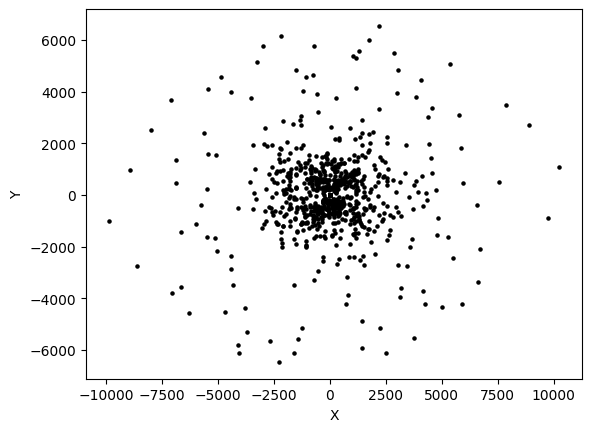

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BL4S 2023/data_raw/histo_10.csv', comment='#', skiprows=7)
print(df.shape)
x_data = df['Sxw0']
y_data = df['Sxw1']
data_matrix = np.vstack((x_data, y_data)).T
print(data_matrix.shape)
plt.scatter(data_matrix[:, 0], data_matrix[:, 1], color='black', s=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

torch.Size([1, 2, 52, 52])


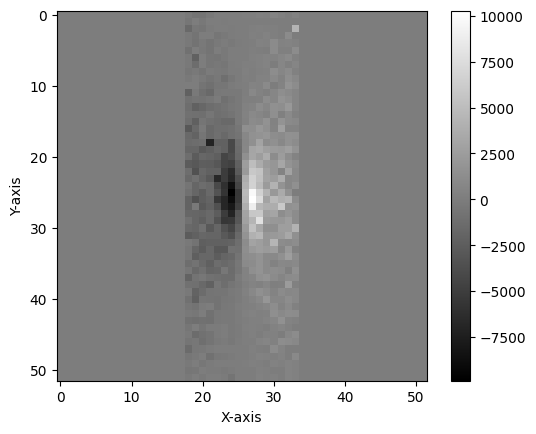

In [ ]:
# Transform to image
hist_array = np.reshape(data_matrix, (52, 52, 2))
hist_tensor = torch.from_numpy(hist_array)
hist_tensor = hist_tensor.permute(2, 0, 1).unsqueeze(0)
print(hist_tensor.shape)
hist_np = hist_tensor.numpy()


fig, ax = plt.subplots()
im = ax.imshow(hist_np[0, 0], cmap='gray')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.show()


In [ ]:
class MyDataset(Dataset):
    def __init__(self, img_dir, csv_file):
        self.img_dir = img_dir
        self.lines = []
        with open(csv_file, 'r') as f:
            for _ in range(18):
                next(f)
            for line in f:
                self.lines.append(line.strip().split(','))

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, index):
        h = pd.read_csv(self.img_dir, comment='#', skiprows=7)
        x_data = h['Sxw0']
        y_data = h['Sxw1']
        data_matrix = np.vstack((x_data, y_data)).T
        hist_array = np.reshape(data_matrix, (52, 52, 2))
        hist_tensor = torch.from_numpy(hist_array)
        img = hist_tensor.permute(2, 0, 1)
        line = self.lines[index]
        array = np.array(line[:-1], dtype=np.float32)
        label = np.array(line[-1:], dtype=np.float32)
        img = torch.tensor(img, dtype=torch.float32)
        array = torch.tensor(array, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return img, array, label

dataset = MyDataset(img_dir='/content/drive/MyDrive/BL4S 2023/data_raw/histo_2.csv', csv_file='/content/drive/MyDrive/BL4S 2023/data_raw/ntuple_1.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 13 * 13 + 13, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x, y):
        print(y.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = torch.cat((x, y), dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
        for i, (images, arrays, labels) in enumerate(tepoch):
            images = images.to(device)
            arrays = arrays.to(device)
            labels = labels.to(device)
            outputs = model(images, arrays)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            tepoch.set_postfix(loss=loss.item())
            tepoch.update()

    epoch_loss = running_loss / len(dataset)
    losses.append(epoch_loss)

print("Training Complete.")

In [ ]:
eval_dataset = MyDataset(img_dir='/content/drive/MyDrive/BL4S 2023/data_raw/histo_3.csv', csv_file='/content/drive/MyDrive/BL4S 2023/data_raw/ntuple_2.csv')

eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=32, shuffle=True)

In [ ]:
# Evaluation

model.eval()
results = []

for l in range(25):
  with torch.no_grad():
      for i, (img, array, label) in enumerate(eval_dataloader):
          img = img.to(device)
          array = array.to(device)
          label = label.to(device)
          output = model(img, array)
          results.append(output)


In [ ]:
print(results[0])

In [ ]:
array_list_np = [tensor.cpu().numpy() for tensor in results]
array_eval = np.array(array_list_np)
print(array_eval.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histogram
num_bins = min(len(array_eval), 30)

# graficar el histograma
plt.hist(array_eval, density=True)
plt.title("Evaluation Histogram")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

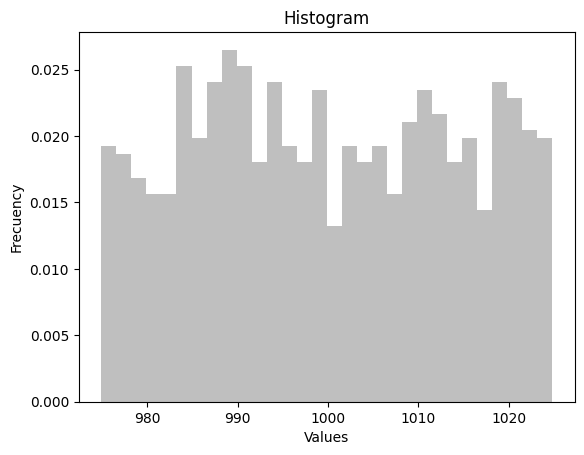

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/BL4S 2023/data_raw/ntuple_1.csv", skiprows=range(18))
column_14 = data.iloc[:, 13].values
plt.hist(column_14, bins=30, density=True, alpha=0.5, color='gray')
plt.title("Histogram")
plt.xlabel("Values")
plt.ylabel("Frecuency")
plt.show()

In [ ]:
flat_list = []
for arr in array_list_np:
    flat_arr = arr.flatten()
    flat_list.extend(flat_arr.tolist())

# Print the flattened list
print(flat_list)

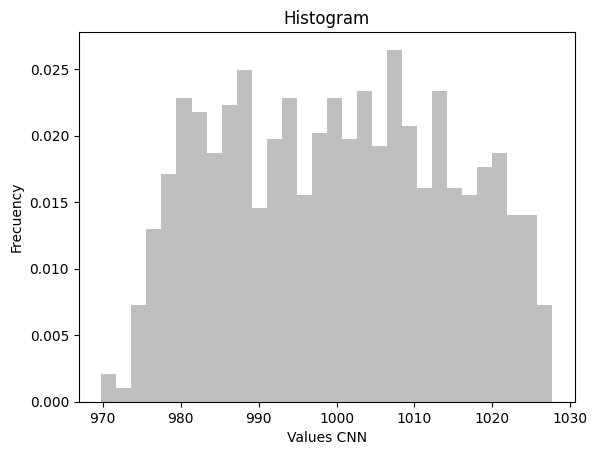

In [ ]:
data = flat_list
plt.hist(data, bins=30, density=True, alpha=0.5, color='Gray')
plt.title("Histogram")
plt.xlabel("Values CNN")
plt.ylabel("Frecuency")
plt.show()